In [1]:
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [7]:
import logging,os

config={'exp_dir':'/root/workspace/wht/multimodal_brain/src/exp/TEST'}
logging.basicConfig(filename=os.path.join(config['exp_dir'],'exp.LOG'), level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',mode='a')
logging.info('start training')

In [2]:
directory = '/root/workspace/wht/multimodal_brain/datasets/things-eeg-small/Image_set/train_images'
dirnames = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
dirnames.sort()

names = [ele.split('_',1)[-1] for ele in dirnames]

tsv_path = '/root/workspace/wht/multimodal_brain/datasets/things/THINGS/27 higher-level categories/category_mat_top_down.tsv'
df1 = pd.read_csv(tsv_path, sep='\t')

tsv_path = '/root/workspace/wht/multimodal_brain/datasets/things/THINGS/things_concepts.tsv'
df2 = pd.read_csv(tsv_path, sep='\t')

df2['uniqueID'].to_csv('word_output.csv', index=False)

df2[['uniqueID','Top-down Category (WordNet)']]

,uniqueID,Top-down Category (WordNet)
0,aardvark,animal
1,abacus,NaN
2,accordion,musical instrument
3,acorn,fruit
4,air_conditioner,NaN
...,...,...
1849,yoke,NaN
1850,yolk,food
1851,zebra,animal
1852,zipper,NaN


In [3]:
def map_to_superclass(sample_class):
    superclass_dict = {
        'animal': 'Animals_Plants',
        'animal, bird': 'Animals_Plants',
        'animal, insect': 'Animals_Plants',
        'plant': 'Animals_Plants',
        
        'food': 'Food_Drink',
        'food, beverage': 'Food_Drink',
        'food, dessert': 'Food_Drink',
        'food, vegetable': 'Food_Drink',
        'fruit': 'Food_Drink',
        'vegetable': 'Food_Drink',
        
        'clothing': 'Clothing_Furniture',
        'container': 'Clothing_Furniture',
        'container, kitchen utensil': 'Clothing_Furniture',
        'decoration': 'Clothing_Furniture',
        'furniture': 'Clothing_Furniture',
        'kitchen appliance': 'Clothing_Furniture',
        'kitchen utensil': 'Clothing_Furniture',
        
        'electronic device': 'Tools_Equipment',
        'musical instrument': 'Tools_Equipment',
        'tool': 'Tools_Equipment',
        'sports equipment': 'Tools_Equipment',
        'sports equipment, weapon': 'Tools_Equipment',
        'weapon': 'Tools_Equipment',
        'toy': 'Tools_Equipment',
        
        'container, vehicle': 'Vehicle',
        'vehicle': 'Vehicle',
        'vehicle, weapon': 'Vehicle',
        
        'body part': 'Other',
        'other': 'Other'
    }
    
    return superclass_dict.get(sample_class, 'UNKNOWN')
map_dict = []
df2['Top-down Category (WordNet)'] = df2['Top-down Category (WordNet)'].fillna('other')
for i,name in enumerate(names):
    Top_down_class = df2[df2['uniqueID'] == name]['Top-down Category (WordNet)'].iloc[0]
    super_class = map_to_superclass(Top_down_class)
    map_dict.append(super_class)
class_labels = {'Animals_Plants': 0, 'Food_Drink': 1, 'Clothing_Furniture': 2, 'Tools_Equipment':3, 'Vehicle':4, 'Other':5}

In [4]:
class EEGDataset(Dataset):
    def __init__(self, file_path, train=True, transform=None,seed=1):
        self.file_path = file_path
        self.train = train
        self.transform = transform
        self.data = []
        self.labels = []
        
        np.random.seed(seed)
        
        with h5py.File(self.file_path, 'r') as h5f:
            data_tensor = h5f['data_tensor'][:]
            label_tensor = h5f['label_tensor'][:]
            unique_labels = np.unique(label_tensor)
            for i,label in enumerate(unique_labels):
                indices = np.where(label_tensor == label)[0]
                np.random.shuffle(indices)
    
                split_idx = int(0.9 * len(indices))
                if self.train:
                    selected_indices = indices[:split_idx]
                else:
                    selected_indices = indices[split_idx:]
                       
                self.data.append(data_tensor[selected_indices])
                self.labels.append(label_tensor[selected_indices])
            
            self.data = np.concatenate(self.data, axis=0)
            self.labels = np.concatenate(self.labels, axis=0)

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        eeg = self.data[idx]
        label = self.labels[idx]
        
        label = class_labels[map_dict[label]]
        
        if self.transform:
            eeg = self.transform(eeg)
        
        return eeg, label

In [8]:
path = '/root/workspace/wht/multimodal_brain/EEG_Image_decode/Retrieval/train.h5'
train_dataset = EEGDataset(path,train=True)
test_dataset = EEGDataset(path,train=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=False)

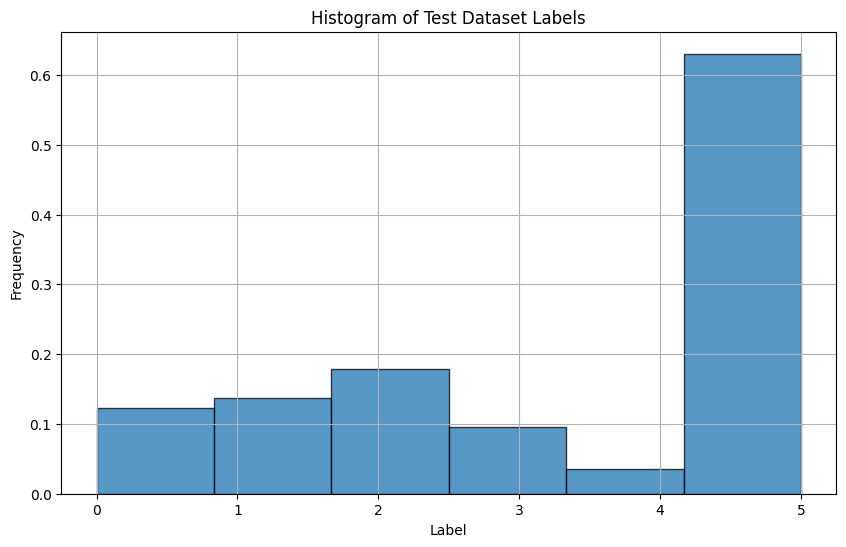

In [6]:
labels=[]
for i in range(len(test_dataset)):
    eeg, label = test_dataset[i]
    labels.append(label)
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=len(set(labels)), alpha=0.75, edgecolor='black', density=True)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Test Dataset Labels')
plt.grid(True)
plt.show()

In [14]:
class EEG_CNN(nn.Module):
    def __init__(self, num_channels, num_timesteps, num_classes):
        super(EEG_CNN, self).__init__()
        # 第一层卷积，处理时间维
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # 第二层卷积
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # 第三层卷积
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        # 计算卷积层输出后的尺寸
        self.num_features_after_conv = 128 * (num_timesteps // 8)
        
        # 分类器
        self.fc = nn.Linear(self.num_features_after_conv, num_classes)

    def forward(self, x):
        # x shape: (batch, channels, timesteps)
        x = torch.unsqueeze(x, 1)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        # 展平操作
        x = x.view(x.size(0), -1)
        
        # 全连接层
        x = self.fc(x)
        return x

In [57]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 250
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 63), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(120, 6)
        

    def forward(self, x):
        
        x = x.unsqueeze(1)
        
        x = x.permute(0, 1, 3, 2)
        
        print(x.shape)
        
        # Layer 1
        x = F.elu(self.conv1(x))        
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        
        
        print(x.shape)
        x = x.permute(0, 3, 1, 2)
        
        print(x.shape)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        print(x.shape)
        # FC Layer
        x = x.reshape(x.size(0), -1)
        print(x.shape)
        x = self.fc1(x)
        print(x.shape)
        return x

In [56]:
num_classes = 6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = EEG_CNN(num_channels=63, num_timesteps=250, num_classes=num_classes)
model = EEGNet()

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(400):
    running_loss = 0.0
    
    correct = 0
    total = 0
    
    model.train()  # 设置模型为训练模式
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 清除梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 打印统计信息
        running_loss += loss.item()
        
    print(f'Epoch {epoch + 1} completed. Train Accuracy: {100 * correct / total:.2f}% Loss: {running_loss/total:.3f}')
    
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
    print(f'Test Accuracy: {100 * test_correct / test_total:.2f}%')
    

torch.Size([128, 1, 250, 63])
torch.Size([128, 16, 250, 1])
torch.Size([128, 1, 16, 250])
torch.Size([128, 4, 2, 15])
torch.Size([128, 120])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x120 and 56x1)